In [1]:
import sys
import pyrealsense2 as rs
from real_robot.utils.realsense import RealSenseAPI
from real_robot.utils.camera import depth2xyz, transform_points

realsense = RealSenseAPI(preset="High Accuracy",
                         depth_option_kwargs={
                             rs.option.exposure: 1500
                         })
color_image, depth_image, intr_array = realsense.capture()

xyz_image = depth2xyz(depth_image, *intr_array)
#world_xyz_image = transform_points(xyz_image, T)
#world_xyz_image.shape

color_image.dtype, color_image.shape, depth_image.shape, intr_array.shape, xyz_image.shape

RealSenseAPI - (realsense.py:161) - INFO - 2023-05-19 11:39 - Found Intel RealSense D435 (S/N: 146322072630 FW: 05.12.09.00 on USB 3.2)
RSDevice - (realsense.py:88) - INFO - 2023-05-19 11:39 - Loaded "High Accuracy" preset for <RSDevice: Intel RealSense D435 (S/N: 146322072630)>
RSDevice - (realsense.py:37) - INFO - 2023-05-19 11:39 - Setting Depth "option.exposure" to 1500
RealSenseAPI - (realsense.py:167) - INFO - 2023-05-19 11:39 - Loading finished: found 1 devices
RSDevice - (realsense.py:100) - INFO - 2023-05-19 11:39 - Started device <RSDevice: Intel RealSense D435 (S/N: 146322072630)> with 2 streams
RSDevice - (realsense.py:102) - INFO - 2023-05-19 11:39 - <pyrealsense2.[video_]stream_profile: Depth(0) 848x480 @ 30fps Z16>
RSDevice - (realsense.py:102) - INFO - 2023-05-19 11:39 - <pyrealsense2.[video_]stream_profile: Color(0) 848x480 @ 30fps RGB8>


(dtype('uint8'), (480, 848, 3), (480, 848), (4,), (480, 848, 3))

In [2]:
from seg_and_track_anything.seg_track_anything import draw_mask, colorize_mask
from mani_skill2.utils.visualization.misc import tile_images

In [3]:
import numpy as np
import cv2
import open3d as o3d
from real_robot.utils.camera import depth2xyz, transform_points

from pyrl.utils.lib3d import np2pcd
def _process_pts(
        pts_lst,
        voxel_downsample_size, nb_neighbors, std_ratio
    ):
        from pyrl.utils.lib3d import np2pcd

        if isinstance(pts_lst, np.ndarray):
            pts_lst = [pts_lst]

        ret_pts_lst = []
        for pts in pts_lst:
            pcd = np2pcd(pts)
            if voxel_downsample_size is not None:
                pcd = pcd.voxel_down_sample(voxel_size=voxel_downsample_size)
            pcd_filter, inlier_inds = pcd.remove_statistical_outlier(
                nb_neighbors=nb_neighbors, std_ratio=std_ratio
            )
            ret_pts_lst.append(np.asarray(pcd_filter.points))

        if len(ret_pts_lst) == 1:
            return ret_pts_lst[0]

        return ret_pts_lst


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
import numpy as np
import cv2
import open3d as o3d

from grounded_sam_track import GroundedSAMTrack
grounded_sam_track = GroundedSAMTrack(predict_gap=9999, device="cuda:1")

camera_pose = np.load("/rl_benchmark/real_robot/notebooks/Tb_b2c.npy")

voxel_downsample_size, nb_neighbors, std_ratio = 0.005, 20, 0.005


ret = grounded_sam_track.predict_and_track_batch(
    [color_image], [0], ["red cube", "green bowl"]
)
pred_mask = ret["pred_masks"][0]

xyz_image = depth2xyz(depth_image, *intr_array)
world_xyz_image = transform_points(xyz_image, camera_pose)

cv2.namedWindow("Color / Depth")
cv2.imshow("Color / Depth", color_image)
cv2.waitKey(1)

pcd_vis = o3d.visualization.Visualizer()
pcd_vis.create_window("Point Cloud", width=1280, height=720)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(world_xyz_image.reshape(-1, 3))
pcd.colors = o3d.utility.Vector3dVector(color_image.reshape(-1, 3) / 255.0)
coord_frame = o3d.geometry.TriangleMesh().create_coordinate_frame()
pcd_vis.add_geometry(coord_frame)
pcd_vis.add_geometry(pcd)

cube_pts = world_xyz_image[pred_mask == 1]
cube_pts = _process_pts(
    cube_pts, voxel_downsample_size, nb_neighbors, std_ratio
)
bowl_pts = world_xyz_image[pred_mask == 2]
bowl_pts = _process_pts(
    bowl_pts, voxel_downsample_size, nb_neighbors, std_ratio
)
cube_pos = np.mean(cube_pts, axis=0)
bowl_pos = np.mean(bowl_pts, axis=0)
# Extract bbox from object_pts
bowl_mins, bowl_maxs = bowl_pts.min(0), bowl_pts.max(0)
cube_mins, cube_maxs = cube_pts.min(0), cube_pts.max(0)

cube_bbox_pos = np.mean([cube_mins, cube_maxs], axis=0)
bowl_bbox_pos = np.mean([bowl_mins, bowl_maxs], axis=0)

pcd_center = o3d.geometry.PointCloud()
pcd_center.points = o3d.utility.Vector3dVector(np.stack([cube_pos, bowl_pos, cube_bbox_pos, bowl_bbox_pos], axis=0))
pcd_center.colors = o3d.utility.Vector3dVector(np.stack([[0, 0, 1], [0, 0, 1], [0, 1, 0], [0, 1, 0.]], axis=0))
pcd_vis.add_geometry(pcd_center)

cube_aabb = np2pcd(cube_pts).get_axis_aligned_bounding_box()
bowl_aabb = np2pcd(bowl_pts).get_axis_aligned_bounding_box()
pcd_vis.add_geometry(cube_aabb)
pcd_vis.add_geometry(bowl_aabb)

while True:
    color_image, depth_image, intr_array = realsense.capture()
    pcd_vis.poll_events()
    pcd_vis.update_renderer()

    depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
    cv2.imshow("Color / Depth", np.hstack([cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR), depth_colormap]))
    key = cv2.waitKey(1)
    if key == 27:  # ESC
        break
    elif key == ord('s'):
        xyz_image = depth2xyz(depth_image, *intr_array)
        world_xyz_image = transform_points(xyz_image, camera_pose)
        pcd.points = o3d.utility.Vector3dVector(world_xyz_image.reshape(-1, 3))
        pcd.colors = o3d.utility.Vector3dVector(color_image.reshape(-1, 3) / 255.0)

        ret = grounded_sam_track.predict_and_track_batch(
            [color_image], [0], ["red cube", "green bowl"]
        )
        pred_mask = ret["pred_masks"][0]

        cube_pts = world_xyz_image[pred_mask == 1]
        cube_pts = _process_pts(
            cube_pts, voxel_downsample_size, nb_neighbors, std_ratio
        )
        bowl_pts = world_xyz_image[pred_mask == 2]
        bowl_pts = _process_pts(
            bowl_pts, voxel_downsample_size, nb_neighbors, std_ratio
        )
        cube_pos = np.mean(cube_pts, axis=0)
        bowl_pos = np.mean(bowl_pts, axis=0)
        # Extract bbox from object_pts
        bowl_mins, bowl_maxs = bowl_pts.min(0), bowl_pts.max(0)
        cube_mins, cube_maxs = cube_pts.min(0), cube_pts.max(0)

        cube_bbox_pos = np.mean([cube_mins, cube_maxs], axis=0)
        bowl_bbox_pos = np.mean([bowl_mins, bowl_maxs], axis=0)

        pcd_center.points = o3d.utility.Vector3dVector(np.stack([cube_pos, bowl_pos, cube_bbox_pos, bowl_bbox_pos], axis=0))
        pcd_center.colors = o3d.utility.Vector3dVector(np.stack([[0, 0, 1], [0, 0, 1], [0, 1, 0], [0, 1, 0.]], axis=0))
        pcd_vis.update_geometry(pcd_center)

        cube_aabb_new = np2pcd(cube_pts).get_axis_aligned_bounding_box()
        bowl_aabb_new = np2pcd(bowl_pts).get_axis_aligned_bounding_box()
        cube_aabb.max_bound = cube_aabb_new.max_bound
        cube_aabb.min_bound = cube_aabb_new.min_bound
        bowl_aabb.max_bound = bowl_aabb_new.max_bound
        bowl_aabb.min_bound = bowl_aabb_new.min_bound
        pcd_vis.update_geometry(cube_aabb)
        pcd_vis.update_geometry(bowl_aabb)

        pcd_vis.update_geometry(pcd)

cv2.destroyAllWindows()
pcd_vis.destroy_window()
del realsense

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])

Loading GroundingDINO: Took 3.082 seconds

Loading SAM: Took 4.191 seconds


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
2023-05-19 11:39:29.735921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
RSDevice - (realsense.py:134) - INFO - 2023-05-19 11:41 - Stopped device <RSDevice: Intel RealSense D435 (S/N: 146322072630)>


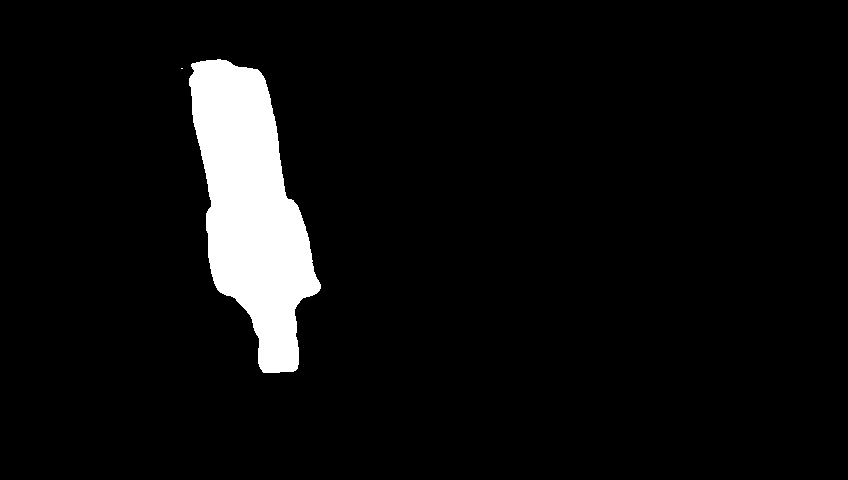

In [5]:
from PIL import Image
Image.fromarray(pred_mask == 1)

In [5]:
xyz_image = depth2xyz(depth_image, *intr_array)
world_xyz_image = transform_points(xyz_image, camera_pose)

cube_pts = world_xyz_image[pred_mask == 1]
# cube_pts = _process_pts(
#     cube_pts, 0.005, 20, 0.005
# )
bowl_pts = world_xyz_image[pred_mask == 2]
# bowl_pts = _process_pts(
#     bowl_pts, 0.005, 20, 0.005
# )
cube_pos = np.mean(cube_pts, axis=0)
bowl_pos = np.mean(bowl_pts, axis=0)
# Extract bbox from object_pts
bowl_mins, bowl_maxs = bowl_pts.min(0), bowl_pts.max(0)
cube_mins, cube_maxs = cube_pts.min(0), cube_pts.max(0)

cube_bbox_pos = np.mean([cube_mins, cube_maxs], axis=0)
bowl_bbox_pos = np.mean([bowl_mins, bowl_maxs], axis=0)

In [6]:
voxel_downsample_size, nb_neighbors, std_ratio = 0.005, 20, 0.005
cube_pcd = np2pcd(cube_pts)
pcd = np2pcd(cube_pts)
if voxel_downsample_size is not None:
    pcd = pcd.voxel_down_sample(voxel_size=voxel_downsample_size)
pcd_filter, inlier_inds = pcd.remove_statistical_outlier(
    nb_neighbors=nb_neighbors, std_ratio=std_ratio
)

o3d.visualization.draw_geometries([cube_pcd, pcd, pcd_filter])

In [8]:
import open3d as o3d

pcd = np2pcd(bowl_pts)
#pcd.remove_statisti
print(f"Before: {len(pcd.points)} points")
pcd = pcd.voxel_down_sample(voxel_size=0.005)
print(f"After downsample: {len(pcd.points)} points")
pcd_filter, inlier_inds = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.005)
#%timeit pcd_filter, inlier_inds = pcd.remove_radius_outlier(nb_points=20, radius=0.1)
print(f"After filter: {len(pcd_filter.points)} points")

inlier_mask = np.zeros(len(pcd.points)).astype(bool)
inlier_mask[inlier_inds] = True

import pyvista as pv
plotter = pv.Plotter(notebook=True)
plotter.add_points(np.asarray(pcd.points)[inlier_mask], color='w', point_size=10.0)
plotter.add_points(np.asarray(pcd.points)[~inlier_mask], color='r', point_size=10.0)
plotter.add_axes()
plotter.add_bounding_box()
plotter.show(jupyter_backend='trame')

Before: 7341 points
After downsample: 433 points
After filter: 403 points


Widget(value="<iframe src='http://localhost:40047/index.html?ui=P_0x7f4e3c232e90_2&reconnect=auto' style='widt…

In [2]:
color_image, depth_image, intr_array = realsense.capture()

RSDevice - (realsense.py:115) - INFO - 2023-05-14 18:54 - Received frame #29


In [3]:
del realsense

RSDevice - (realsense.py:134) - INFO - 2023-05-14 18:54 - Stopped device <RSDevice: Intel RealSense D435 (S/N: 146322070293)>
